# Day 4 Advanced: Transfer Learning with ResNet50

**Goal:** Achieve 89-92% accuracy using ResNet50

**What we'll do:**
1. Load ResNet50 pretrained on ImageNet
2. Convert grayscale images to RGB
3. Fine-tune the model on brain tumor data
4. Compare with baseline (76.83%) and EfficientNet

**Expected improvement:** 76% ‚Üí 89-92% (+13-16%)

**Why ResNet50?**
- Deep residual connections (50 layers)
- Excellent feature learning
- Proven performance on medical imaging
- 25M parameters (more capacity than EfficientNet)

---

**Training Strategy:**
1. **Phase 1:** Freeze base model, train classifier (5 epochs)
2. **Phase 2:** Unfreeze top ResNet blocks, fine-tune (12 epochs)
3. **Phase 3:** Lower learning rate, final training (8 epochs)

**Expected time:** 60-90 minutes (with GPU)

---

## 1. Import Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam

# Add src to path for imports
sys.path.append('../../src')
from training.transfer_learning_utils import GrayscaleToRGBGenerator, create_rgb_generators

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"‚úÖ GPU available: {len(gpus)} GPU(s)")
else:
    print("‚ö†Ô∏è  No GPU - training will be slow!")

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

2025-10-24 21:55:06.954187: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
Keras version: 3.11.3
‚úÖ GPU available: 1 GPU(s)


## 2. Configuration

In [2]:
# Paths
TRAIN_CSV = "../../outputs/data_splits/train_split.csv"
VAL_CSV = "../../outputs/data_splits/val_split.csv"
TEST_CSV = "../../outputs/data_splits/test_split.csv"

# Output directories
MODEL_DIR = "../../outputs/models/transfer_learning"
HISTORY_DIR = "../../outputs/training_history/transfer_learning"
VIZ_DIR = "../../outputs/visualizations"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(HISTORY_DIR, exist_ok=True)
os.makedirs(VIZ_DIR, exist_ok=True)

# Hyperparameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
LEARNING_RATE_PHASE1 = 0.001  # Training classifier only
LEARNING_RATE_PHASE2 = 0.0001  # Fine-tuning
LEARNING_RATE_PHASE3 = 0.00001  # Final training

# Class names
CLASS_NAMES = ['glioma', 'meningioma', 'pituitary']
NUM_CLASSES = len(CLASS_NAMES)

print("Configuration:")
print(f"  Model: ResNet50")
print(f"  Image size: {IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Classes: {CLASS_NAMES}")

Configuration:
  Model: ResNet50
  Image size: (128, 128)
  Batch size: 32
  Classes: ['glioma', 'meningioma', 'pituitary']


## 3. Load Data

In [3]:
# Load CSV files
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

# Ensure label is string
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

print("Data loaded:")
print(f"  Train: {len(train_df)} images")
print(f"  Val:   {len(val_df)} images")
print(f"  Test:  {len(test_df)} images")

Data loaded:
  Train: 4863 images
  Val:   855 images
  Test:  1463 images


## 4. Create RGB Data Generators

In [4]:
# Create RGB generators using utility function
train_generator, val_generator, test_generator = create_rgb_generators(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print("\n‚úÖ RGB data generators created!")
print(f"Steps per epoch: {len(train_generator)}")
print(f"Validation steps: {len(val_generator)}")

# Test generator output
test_batch_x, test_batch_y = next(iter(train_generator))
print(f"\nBatch shape: {test_batch_x.shape} (should be [batch, 128, 128, 3])")
print(f"Labels shape: {test_batch_y.shape}")

Found 4863 validated image filenames belonging to 3 classes.
Found 855 validated image filenames belonging to 3 classes.
Found 855 validated image filenames belonging to 3 classes.
Found 1463 validated image filenames belonging to 3 classes.
Found 1463 validated image filenames belonging to 3 classes.

‚úÖ RGB data generators created!
Steps per epoch: 152
Validation steps: 27

Batch shape: (32, 128, 128, 3) (should be [batch, 128, 128, 3])
Labels shape: (32, 3)

‚úÖ RGB data generators created!
Steps per epoch: 152
Validation steps: 27

Batch shape: (32, 128, 128, 3) (should be [batch, 128, 128, 3])
Labels shape: (32, 3)


## 5. Build Transfer Learning Model

**Architecture:**
- Base: ResNet50 (pretrained on ImageNet)
- GlobalAveragePooling2D
- Dense(512) + BatchNorm + Dropout
- Dense(256) + BatchNorm + Dropout
- Dense(3, softmax)

In [5]:
def build_resnet_model(num_classes=3, trainable=False):
    """
    Build ResNet50 model with custom classifier.
    
    Args:
        num_classes: Number of output classes
        trainable: Whether base model is trainable
    
    Returns:
        Compiled Keras model
    """
    # Load pretrained ResNet50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3)
    )
    
    # Freeze/unfreeze base model
    base_model.trainable = trainable
    
    # Build full model
    inputs = keras.Input(shape=(128, 128, 3))
    x = base_model(inputs, training=False)  # Set training=False for inference mode
    x = GlobalAveragePooling2D()(x)
    
    # Custom classifier (larger than EfficientNet)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model, base_model

# Build model (base frozen initially)
model, base_model = build_resnet_model(num_classes=NUM_CLASSES, trainable=False)

print("Model architecture:")
model.summary()

# Count parameters
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = sum([tf.size(w).numpy() for w in model.non_trainable_weights])
total_params = trainable_params + non_trainable_params

print(f"\nParameter counts:")
print(f"  Trainable: {trainable_params:,}")
print(f"  Non-trainable: {non_trainable_params:,}")
print(f"  Total: {total_params:,}")

I0000 00:00:1761323109.730368   49092 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2614 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model architecture:


Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_1 (InputLayer)      ‚îÇ (None, 128, 128, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ resnet50 (Functional)           ‚îÇ (None, 4, 4, 2048)     ‚îÇ    23,587,712 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (None, 2048)           ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 512)            ‚îÇ     1,049,088 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 512)            ‚îÇ         2,048 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 512)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 256)            ‚îÇ       131,328 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 256)            ‚îÇ         1,024 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 3)              ‚îÇ           771 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 24,771,971 (94.50 MB)

 Trainable params: 1,182,723 (4.51 MB)

 Non-trainable params: 23,589,248 (89.99 MB)


Parameter counts:
  Trainable: 1,182,723
  Non-trainable: 23,589,248
  Total: 24,771,971


## 6. Phase 1: Train Classifier Only (5 epochs)

In [6]:
print("="*70)
print("PHASE 1: Training Classifier Only")
print("="*70)
print("Base model: FROZEN")
print("Learning rate: 0.001")
print("Epochs: 5\n")

# Compile model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE1),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
callbacks_phase1 = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

# Train
history_phase1 = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=callbacks_phase1,
    verbose=1
)

print("\n‚úÖ Phase 1 completed!")
print(f"Final accuracy: {history_phase1.history['accuracy'][-1]:.4f}")
print(f"Final val_accuracy: {history_phase1.history['val_accuracy'][-1]:.4f}")

PHASE 1: Training Classifier Only
Base model: FROZEN
Learning rate: 0.001
Epochs: 5

Epoch 1/5
Epoch 1/5


/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-10-24 21:55:17.341598: I external/local_xla/xla/service/service.cc:163] XLA service 0x787580002310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-24 21:55:17.341625: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-10-24 21:55:17.513781: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-24 21:55:17.341598: I external/local_xla/xla/service/service

  3/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 68ms/step - accuracy: 0.3333 - loss: 2.2242

I0000 00:00:1761323123.571545   49156 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


151/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 71ms/step - accuracy: 0.6210 - loss: 1.1411

2025-10-24 21:55:36.096600: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[31,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,64,32,32]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-24 21:55:36.459255: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[31,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,128,16,16]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target

152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 107ms/step - accuracy: 0.6214 - loss: 1.1397

2025-10-24 21:55:44.875745: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[23,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,64,32,32]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-24 21:55:45.168176: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[23,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,128,16,16]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target

152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 35s 156ms/step - accuracy: 0.6817 - loss: 0.9260 - val_accuracy: 0.7789 - val_loss: 0.6142 - learning_rate: 0.0010
Epoch 2/5
Epoch 2/5
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 77ms/step - accuracy: 0.7590 - loss: 0.6497 - val_accuracy: 0.7895 - val_loss: 0.5106 - learning_rate: 0.0010
Epoch 3/5
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 77ms/step - accuracy: 0.7590 - loss: 0.6497 - val_accuracy: 0.7895 - val_loss: 0.5106 - learning_rate: 0.0010
Epoch 3/5
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 78ms/step - accuracy: 0.7754 - loss: 0.5556 - val_accuracy: 0.7953 - val_loss: 0.5471 - learning_rate: 0.0010
Epoch 4/5
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 78ms/step - accuracy: 0.7754 - loss: 0.5556 - val_accuracy: 0.7953 - val_loss: 0.5471 - learning_rate: 0.0010
Epoch 4/5
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

## 7. Phase 2: Fine-tune Top Layers (12 epochs)

In [7]:
print("\n" + "="*70)
print("PHASE 2: Fine-tuning Top Layers")
print("="*70)

# Unfreeze last residual blocks (conv5)
base_model.trainable = True

# Freeze bottom layers (keep conv1-conv4 frozen)
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Count trainable layers
trainable_layers = sum([layer.trainable for layer in base_model.layers])
print(f"Trainable layers in base model: {trainable_layers} / {len(base_model.layers)}")

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE2),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Learning rate: {LEARNING_RATE_PHASE2}")
print(f"Epochs: 12\n")

# Callbacks
model_path_phase2 = os.path.join(MODEL_DIR, f"resnet50_phase2_{timestamp}.keras")
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=model_path_phase2,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    )
]

# Train
history_phase2 = model.fit(
    train_generator,
    epochs=12,
    validation_data=val_generator,
    callbacks=callbacks_phase2,
    verbose=1
)

print("\n‚úÖ Phase 2 completed!")
print(f"Best val_accuracy: {max(history_phase2.history['val_accuracy']):.4f}")


PHASE 2: Fine-tuning Top Layers
Trainable layers in base model: 30 / 175
Learning rate: 0.0001
Epochs: 12

Epoch 1/12
125/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 104ms/step - accuracy: 0.7959 - loss: 0.5015

2025-10-24 21:57:06.070234: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-24 21:57:06.293404: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-24 21:57:06.293404: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 147ms/step - accuracy: 0.7997 - loss: 0.4949
Epoch 1: val_loss improved from None to 0.47528, saving model to ../../outputs/models/transfer_learning/resnet50_phase2_20251024_215511.keras

Epoch 1: val_loss improved from None to 0.47528, saving model to ../../outputs/models/transfer_learning/resnet50_phase2_20251024_215511.keras
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 44s 194ms/step - accuracy: 0.8180 - loss: 0.4643 - val_accuracy: 0.8105 - val_loss: 0.4753 - learning_rate: 1.0000e-04
Epoch 2/12
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 44s 194ms/step - accuracy: 0.8180 - loss: 0.4643 - val_accuracy: 0.8105 - val_loss: 0.4753 - learning_rate: 1.0000e-04
Epoch 2/12
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 104ms/step - accuracy: 0.8625 - loss: 0.3468
Epoch 2: val_loss improved from 0.47528 to 0.40565, saving model to ../../outputs/m

## 8. Phase 3: Final Training (8 epochs)

In [8]:
print("\n" + "="*70)
print("PHASE 3: Final Training")
print("="*70)

# Unfreeze all layers
base_model.trainable = True
for layer in base_model.layers:
    layer.trainable = True

print(f"All layers unfrozen")
print(f"Learning rate: {LEARNING_RATE_PHASE3}")
print(f"Epochs: 8\n")

# Recompile with very low learning rate
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
model_path_final = os.path.join(MODEL_DIR, f"resnet50_final_{timestamp}.keras")
history_csv = os.path.join(HISTORY_DIR, f"resnet50_history_{timestamp}.csv")

callbacks_phase3 = [
    EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=model_path_final,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    CSVLogger(filename=history_csv)
]

# Train
history_phase3 = model.fit(
    train_generator,
    epochs=8,
    validation_data=val_generator,
    callbacks=callbacks_phase3,
    verbose=1
)

print("\n‚úÖ Phase 3 completed!")
print(f"Final model saved to: {model_path_final}")


PHASE 3: Final Training
All layers unfrozen
Learning rate: 1e-05
Epochs: 8

Epoch 1/8
Epoch 1/8
 43/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 218ms/step - accuracy: 0.8628 - loss: 0.3722

2025-10-24 22:01:35.936127: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 339ms/step - accuracy: 0.8805 - loss: 0.3230
Epoch 1: val_loss improved from None to 0.37541, saving model to ../../outputs/models/transfer_learning/resnet50_final_20251024_215511.keras

Epoch 1: val_loss improved from None to 0.37541, saving model to ../../outputs/models/transfer_learning/resnet50_final_20251024_215511.keras
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 99s 386ms/step - accuracy: 0.8957 - loss: 0.2783 - val_accuracy: 0.8702 - val_loss: 0.3754
Epoch 2/8
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 99s 386ms/step - accuracy: 0.8957 - loss: 0.2783 - val_accuracy: 0.8702 - val_loss: 0.3754
Epoch 2/8
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 218ms/step - accuracy: 0.9178 - loss: 0.2231
Epoch 2: val_loss did not improve from 0.37541
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 35s 228ms/step - accuracy: 

## 9. Combine Training History

In [9]:
# Combine histories from all phases
combined_history = {
    'accuracy': (history_phase1.history['accuracy'] + 
                 history_phase2.history['accuracy'] + 
                 history_phase3.history['accuracy']),
    'val_accuracy': (history_phase1.history['val_accuracy'] + 
                     history_phase2.history['val_accuracy'] + 
                     history_phase3.history['val_accuracy']),
    'loss': (history_phase1.history['loss'] + 
             history_phase2.history['loss'] + 
             history_phase3.history['loss']),
    'val_loss': (history_phase1.history['val_loss'] + 
                 history_phase2.history['val_loss'] + 
                 history_phase3.history['val_loss'])
}

print(f"Total epochs: {len(combined_history['accuracy'])}")
print(f"Best val_accuracy: {max(combined_history['val_accuracy']):.4f}")

Total epochs: 25
Best val_accuracy: 0.9310


## 10. Visualize Training History

Training curves saved to: ../../outputs/visualizations/day4_advanced_resnet50_history_20251024_215511.png


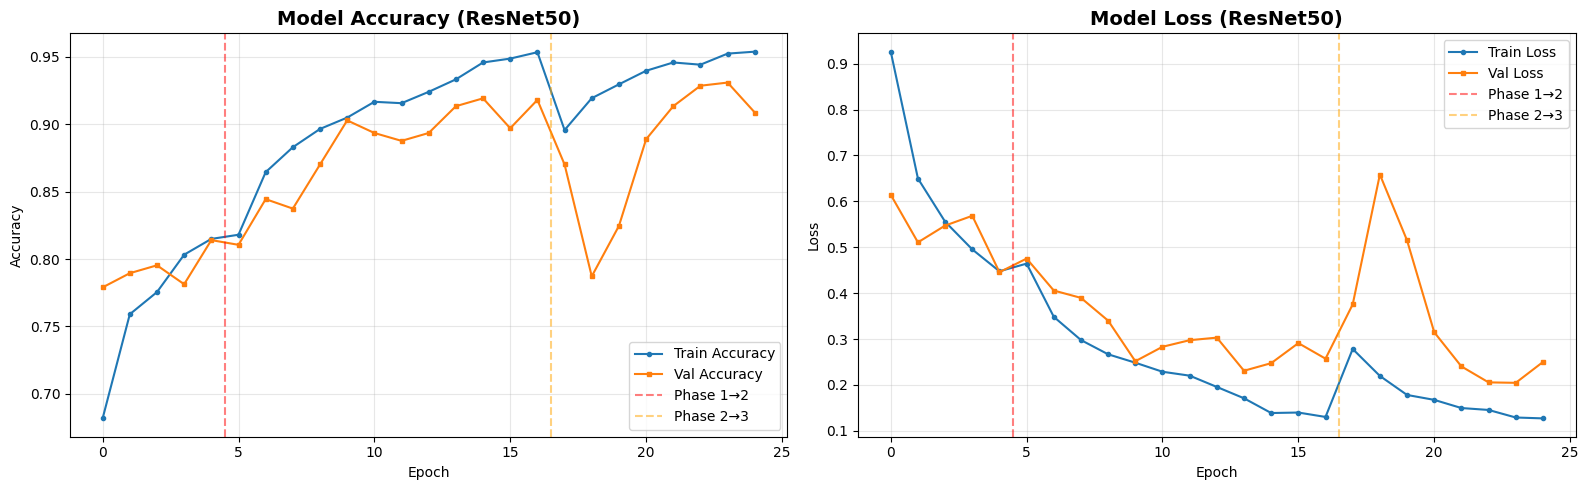

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Mark phase boundaries
phase1_end = len(history_phase1.history['accuracy'])
phase2_end = phase1_end + len(history_phase2.history['accuracy'])

# Plot accuracy
ax1.plot(combined_history['accuracy'], label='Train Accuracy', marker='o', markersize=3)
ax1.plot(combined_history['val_accuracy'], label='Val Accuracy', marker='s', markersize=3)
ax1.axvline(x=phase1_end-0.5, color='red', linestyle='--', alpha=0.5, label='Phase 1‚Üí2')
ax1.axvline(x=phase2_end-0.5, color='orange', linestyle='--', alpha=0.5, label='Phase 2‚Üí3')
ax1.set_title('Model Accuracy (ResNet50)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot loss
ax2.plot(combined_history['loss'], label='Train Loss', marker='o', markersize=3)
ax2.plot(combined_history['val_loss'], label='Val Loss', marker='s', markersize=3)
ax2.axvline(x=phase1_end-0.5, color='red', linestyle='--', alpha=0.5, label='Phase 1‚Üí2')
ax2.axvline(x=phase2_end-0.5, color='orange', linestyle='--', alpha=0.5, label='Phase 2‚Üí3')
ax2.set_title('Model Loss (ResNet50)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

viz_path = os.path.join(VIZ_DIR, f"day4_advanced_resnet50_history_{timestamp}.png")
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"Training curves saved to: {viz_path}")

plt.show()

## 11. Evaluate on Test Set

In [11]:
print("üîç Evaluating on test set...\n")

# Evaluate
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\n{'='*70}")
print(f"üìä ResNet50 Test Results")
print(f"{'='*70}")
print(f"  Test Loss:     {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'='*70}")

# Compare with baseline
baseline_accuracy = 0.7683  # From day4_01
improvement = (test_accuracy - baseline_accuracy) * 100

print(f"\nüí° Comparison with Baseline CNN:")
print(f"  Baseline:  76.83%")
print(f"  ResNet50:  {test_accuracy*100:.2f}%")
print(f"  Improvement: {improvement:+.2f}%")

# Save results
results = {
    'model': 'ResNet50',
    'timestamp': timestamp,
    'test_loss': float(test_loss),
    'test_accuracy': float(test_accuracy),
    'baseline_accuracy': float(baseline_accuracy),
    'improvement': float(improvement),
    'total_epochs': len(combined_history['accuracy']),
    'model_path': model_path_final
}

results_path = os.path.join(HISTORY_DIR, f"resnet50_results_{timestamp}.json")
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to: {results_path}")

üîç Evaluating on test set...

46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 65ms/step - accuracy: 0.9187 - loss: 0.2397
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 65ms/step - accuracy: 0.9187 - loss: 0.2397

üìä ResNet50 Test Results
  Test Loss:     0.2397
  Test Accuracy: 0.9187 (91.87%)

üí° Comparison with Baseline CNN:
  Baseline:  76.83%
  ResNet50:  91.87%
  Improvement: +15.04%

Results saved to: ../../outputs/training_history/transfer_learning/resnet50_results_20251024_215511.json

üìä ResNet50 Test Results
  Test Loss:     0.2397
  Test Accuracy: 0.9187 (91.87%)

üí° Comparison with Baseline CNN:
  Baseline:  76.83%
  ResNet50:  91.87%
  Improvement: +15.04%

Results saved to: ../../outputs/training_history/transfer_learning/resnet50_results_20251024_215511.json


## 12. Summary

In [ ]:
print("\n" + "="*70)
print("üéâ RESNET50 TRAINING COMPLETE!")
print("="*70)

print("\nüìä Final Results:")
print(f"  Model: ResNet50")
print(f"  Test Accuracy: {test_accuracy*100:.2f}%")
print(f"  Baseline: 76.83%")
print(f"  Improvement: {improvement:+.2f}%")

print("\nüìÅ Files Created:")
print(f"  ‚úÖ Final Model: {model_path_final}")
print(f"  ‚úÖ History CSV: {history_csv}")
print(f"  ‚úÖ Results JSON: {results_path}")
print(f"  ‚úÖ Visualization: {viz_path}")

print("\nüéØ Next Steps:")
print("  1. Train DenseNet121 (day4_advanced_densenet121.ipynb)")
print("  2. Create ensemble (day4_advanced_ensemble.ipynb)")
print("  3. Expected ensemble accuracy: 92-95%")

print("\nüí° Interpretation:")
if test_accuracy >= 0.92:
    print("  üåü Outstanding! Excellent performance!")
elif test_accuracy >= 0.88:
    print("  ‚úÖ Excellent! Significant improvement over baseline!")
elif test_accuracy >= 0.82:
    print("  ‚úÖ Good! Notable improvement!")
else:
    print("  ‚ö†Ô∏è  Moderate improvement - try adjusting hyperparameters")

print("\n" + "="*70)


üéâ RESNET50 TRAINING COMPLETE!

üìä Final Results:
  Model: ResNet50
  Test Accuracy: 91.87%
  Baseline: 76.83%
  Improvement: +15.04%

üìÅ Files Created:
  ‚úÖ Final Model: ../../outputs/models/transfer_learning/resnet50_final_20251024_215511.keras
  ‚úÖ History CSV: ../../outputs/training_history/transfer_learning/resnet50_history_20251024_215511.csv
  ‚úÖ Results JSON: ../../outputs/training_history/transfer_learning/resnet50_results_20251024_215511.json
  ‚úÖ Visualization: ../../outputs/visualizations/day4_advanced_resnet50_history_20251024_215511.png

üéØ Next Steps:
  1. Train DenseNet121 (day4_advanced_densenet121.ipynb)
  2. Create ensemble (day4_advanced_ensemble.ipynb)
  3. Expected ensemble accuracy: 92-95%

üí° Interpretation:
  ‚úÖ Excellent! Significant improvement over baseline!



: 